# Лабораторная работа №2
Выполнил студент группы 9382 Павлов Роман, вариант 10

### Цель работы:
Практическое применение дискретного преобразования Фурье с использованием библиотек Python для анализа речевых сигналов.

### Задачи:
1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.
2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса.
3. Построить сонограмму по записи своего голоса.

## Подготовка к выполнению работы
При выполнении работы используются библиотеки <b>numpy</b>, <b>scipy</b> для обработки сигнала, а также <b>matplotlib</b> для отображения результатов обработки.

In [8]:
from scipy.fft import fft, ifft, dct
import scipy.io.wavfile as writer
import numpy as np
import matplotlib.pyplot as plt

Заданы размерность ДПФ (длина фрейма) $n$ и коэффициент $m$ для оценки амплитудных максимумов.
Определена функция <b>detFormant</b> определения очередной формантной частоты.

In [9]:
n = 700 # Размерность ДПФ
m = 1 # Коэффициент абсолютного максимум

rate, source = writer.read("sample.wav")
sLength = len(source)
resol = rate/n # Разрешение ДПФ
counts = (int(80/resol), int(200/resol)) # интервал поиска ЧОТ в отсчётах
formants = [[] for i in range(4)]
sonogram = [[] for i in range(n//2)]

# Определение форманты порядка order
def detFormant(lowest, frame, foll=False, prevMax=None, order = 0):
    maxAmp = 0
    meanAmp = 0
    for ampInd in range(len(frame)):
        if frame[ampInd] > frame[maxAmp]:
            maxAmp = ampInd
        meanAmp += frame[ampInd]
    meanAmp /= len(frame)
    if (frame[maxAmp]-meanAmp)/meanAmp > m:
        if (not foll) or (frame[maxAmp]/prevMax < 1 - 0.1*order):
            return lowest+maxAmp
    return 0

### Построение траектории основного тона
Ниже описан цикл, перебирающий фреймы с наложением, равным четверти фрейма. Для каждого фрейма выполняется преобразование Фурье, в амплитудном спектре ведётся поиск существенных максимумов, после чего, если частота основного тона ненулевая, ищутся последующие форманты.

In [10]:
for f0 in range(0, sLength, int(0.75*n)):
    cutLength = 0.75 # Процент "среза" фрейма из-за наложения
    if f0 == 0:
        cutLength = 1
    if f0 + n < sLength:
        interval = list(source[f0:f0+n])
    else:
        interval = list(source[f0:])
    
    window = np.hamming(len(interval))
    interval = list(map(lambda arg: arg*window[interval.index(arg)], interval))
    #transformed = fft(np.array(interval)) # Быстрое ПФ
    transformed = dct(np.array(interval), type = 2) # Дискретное ПФ 2-го типа
    transformed = list(map(lambda x: abs(x), transformed[:len(interval)//2]))
    
    mainFreq = detFormant(counts[0], transformed[counts[0]:counts[1]+1])
    formants[0] += [mainFreq*resol for i in range(int(len(interval)*cutLength))]
    
    # Поиск последующих формант в окрестностях i*F0
    for i in range(1,4):
        if mainFreq != 0:
            lowest = (i+1)*mainFreq - (counts[1]-counts[0])//2
            highest = lowest + (counts[1]-counts[0])
            formant = detFormant(lowest, transformed[lowest:highest], True, transformed[mainFreq], i)
            formants[i] += [formant*resol for j in range(int(len(interval)*cutLength))]
        else:
            formants[i] += [0 for j in range(int(len(interval)*cutLength))]


1-я форманта (частота основного тона):


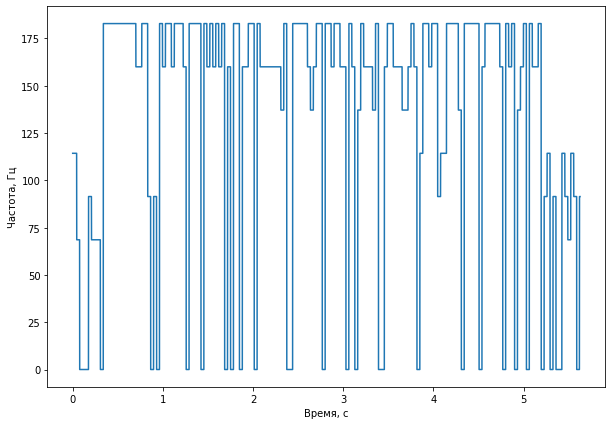

Средняя ЧОТ: 160.93


In [11]:
print("\n1-я форманта (частота основного тона):")
plt.figure(figsize=(10,7))
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.plot(np.arange(len(formants[0]))/rate, formants[0])
plt.show()

meanFreq = 0 # Вычисление среднего значения ЧОТ
leng = 0
for i in formants[0]:
    if i > 0:
        meanFreq += i
        leng += 1
meanFreq /= leng
print("Средняя ЧОТ: %.2f"%meanFreq)

Несмотря на то, что средняя ЧОТ - 160 Гц, её истинное значение, вероятно, ближе к 170 Гц. Впрочем, колебания частоты могли быть вызваны разнообразием интонаций в записи.

### Построение траекторий 2-й, 3-й и 4-й формант
На основании значений, полученных в ходе выполнения цикла выше, выводятся траектории частот формант.


2-я форманта:

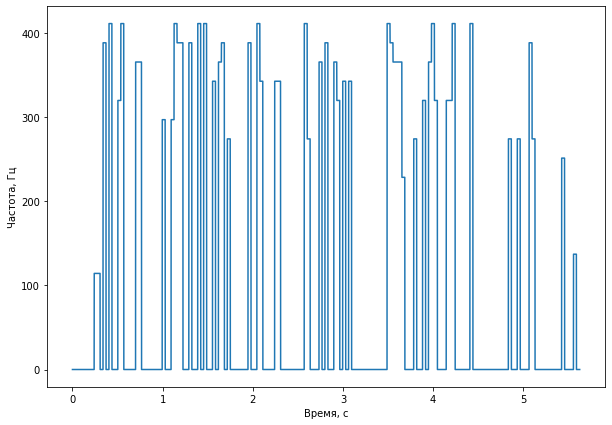


3-я форманта:

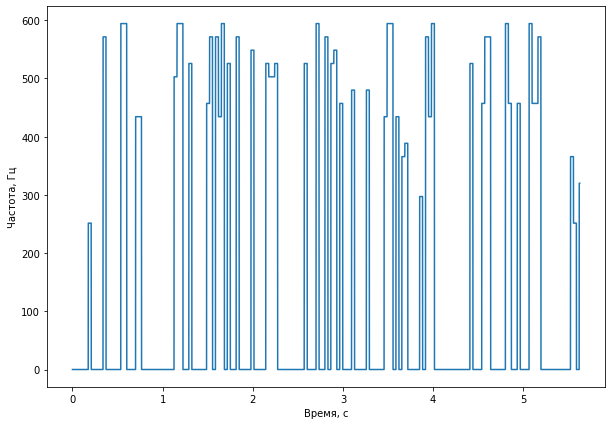


4-я форманта:

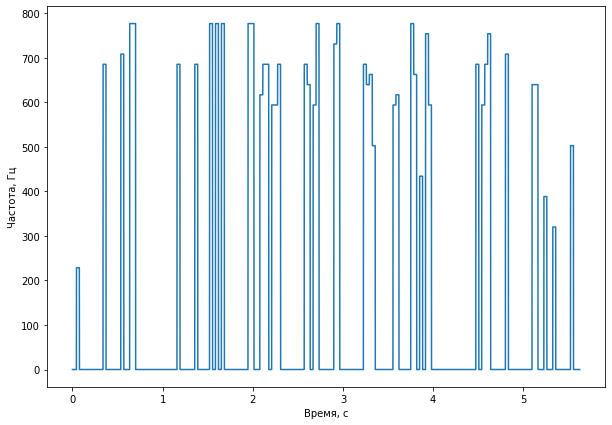

In [12]:
for i in range(1, 4):
    print("\n%d-я форманта:"%(i+1), end="")
    plt.figure(figsize=(10,7))
    plt.xlabel("Время, с")
    plt.ylabel("Частота, Гц")
    plt.plot(np.arange(len(formants[i]))/rate, formants[i])
    plt.show()

Из полученных результатов заметно, что значения формантных частот с некоторой погрешностью кратны значению ЧОТ, что подтверждает теоретические сведения.

### Построение сонограммы по записи голоса
В цикле, представленном ниже, ведётся поиск участков амплитудного спектра сигнала. Участки спектра записываются в список значений сонограммы.

In [13]:
# Нахождение и запись амплитудных спектров (без перекрытия)
for f0 in range(0, sLength, n):
    if f0 + n < sLength:
        interval = list(source[f0:f0+n])
    else:
        interval = list(source[f0:])
    
    window = np.hamming(len(interval))
    interval = list(map(lambda arg: arg*window[interval.index(arg)], interval))
    #transformed = fft(np.array(interval)) # Быстрое ПФ
    transformed = dct(np.array(interval), type = 2) # Дискретное ПФ 2-го типа
    transformed = list(map(lambda x: abs(x), transformed[:len(interval)//2]))
    
    ind = 0
    for elem in np.true_divide(transformed, max(transformed)):
        sonogram[ind].append(elem)
        ind += 1
    if ind < n//2:
        while ind > 0:
            ind -= 1
            sonogram[ind].pop()

На основании полученных данных приводятся изображения осциллограммы и сонограммы (спектрограммы) звукового сигнала для сравнения.


Осциллограмма:


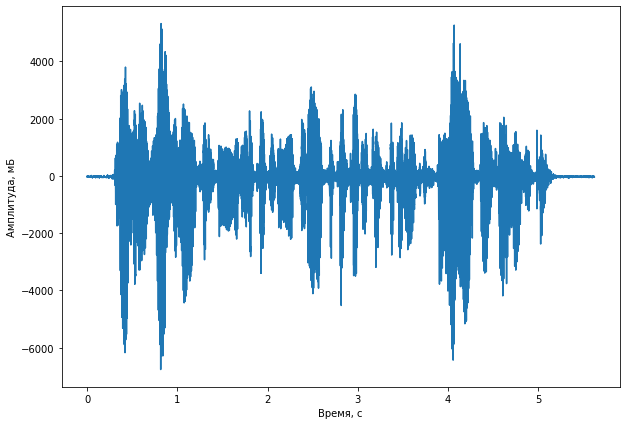

Сонограмма:


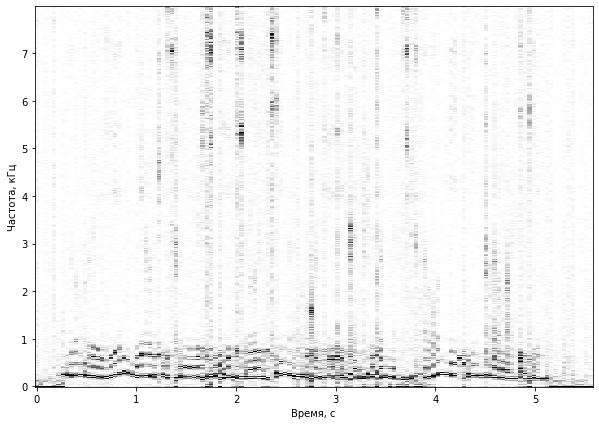

In [14]:
print("\nОсциллограмма:")
plt.figure(figsize=(10,7))
plt.xlabel("Время, с")
plt.ylabel("Амплитуда, мБ")
plt.plot(np.arange(sLength)/rate, source)
plt.show()

print("Сонограмма:")
plt.figure(figsize=(10,7))
plt.xlabel("Время, с")
plt.ylabel("Частота, кГц")
time = np.arange(len(sonogram[0]))/resol
freqs = np.arange(len(sonogram))*resol/1000
plt.pcolormesh(time, freqs, sonogram, cmap = plt.cm.gray_r, shading='auto')
plt.show()

На сонограмме явно выражены частоты величиной до 1 кГц - это ЧОТ и последующие формантные частоты.

### Вывод
В ходе выполнения лабораторной работы была освоена возможность частотного анализа вещественного сигнала с помощью дискретного преобразования Фурье и с использованием библиотек Python.